## Fashion Item Recognition with MLP

> Antonopoulos Ilias (p3352004) <br />
> Ndoja Silva (p3352017) <br />
> MSc Data Science AUEB

## Table of Contents

- [Data Loading](#Data-Loading)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Hyperparameter Tuning](#Hyperparameter-Tuning)
- [Model Selection](#Model-Selection)
- [Evaluation](#Evaluation)

In [1]:
import gc
import itertools
from ast import literal_eval

import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from matplotlib import offsetbox
from sklearn import decomposition
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Normalizer, StandardScaler

In [2]:
print(tf.__version__)

2.8.0


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  0


### Data Loading

In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [5]:
train_images.shape

(60000, 28, 28)

In [6]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [7]:
set(train_labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [8]:
test_images.shape

(10000, 28, 28)

This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories,
  along with a test set of 10,000 images.
  
The classes are:
  
| Label | Description |
|:-----:|-------------|
|   0   | T-shirt/top |
|   1   | Trouser     |
|   2   | Pullover    |
|   3   | Dress       |
|   4   | Coat        |
|   5   | Sandal      |
|   6   | Shirt       |
|   7   | Sneaker     |
|   8   | Bag         |
|   9   | Ankle boot  |

In [9]:
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

### Exploratory Data Analysis

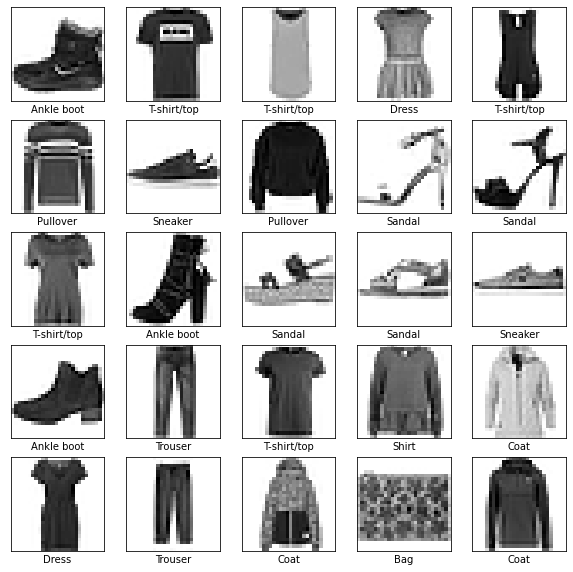

In [10]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [11]:
def visualize_input(img, ax):
    ax.imshow(img, cmap="summer")
    width, height = img.shape
    thresh = img.max() / 2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(
                str(round(img[x][y], 2)),
                xy=(y, x),
                horizontalalignment="center",
                verticalalignment="center",
                color="white" if img[x][y] < thresh else "black",
            )

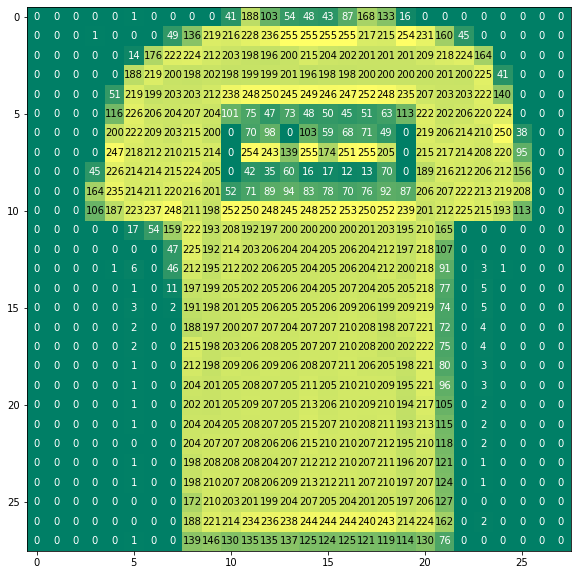

In [12]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
visualize_input(train_images[1], ax)
plt.show()

In [13]:
X_train = train_images.copy().reshape(60000, 784)

y_train = train_labels.copy()

X_train_standardized = StandardScaler().fit_transform(X_train)

X_train_normalized = Normalizer().fit_transform(X_train_standardized)

X_train_tsne = TSNE(n_components=2, init="random", learning_rate=200).fit_transform(
    X_train_normalized
)

In [14]:
colors = [
    "rgb(0,31,63)",
    "rgb(255,133,27)",
    "rgb(255,65,54)",
    "rgb(0,116,217)",
    "rgb(133,20,75)",
    "rgb(57,204,204)",
    "rgb(240,18,190)",
    "rgb(46,204,64)",
    "rgb(1,255,112)",
    "rgb(255,220,0)",
    "rgb(76,114,176)",
    "rgb(85,168,104)",
    "rgb(129,114,178)",
    "rgb(100,181,205)",
]

In [15]:
def plot_tsne_embedding(X_train_tsne, y):
    plt.rcParams["figure.figsize"] = [21, 18]
    for k, i in enumerate(np.unique(y.astype(int))):
        plt.scatter(
            X_train_tsne[y == i, 0],
            X_train_tsne[y == i, 1],
            color="#%02x%02x%02x" % literal_eval(colors[k][3:]),
            label=class_names[k],
        )
    plt.legend()
    plt.show()

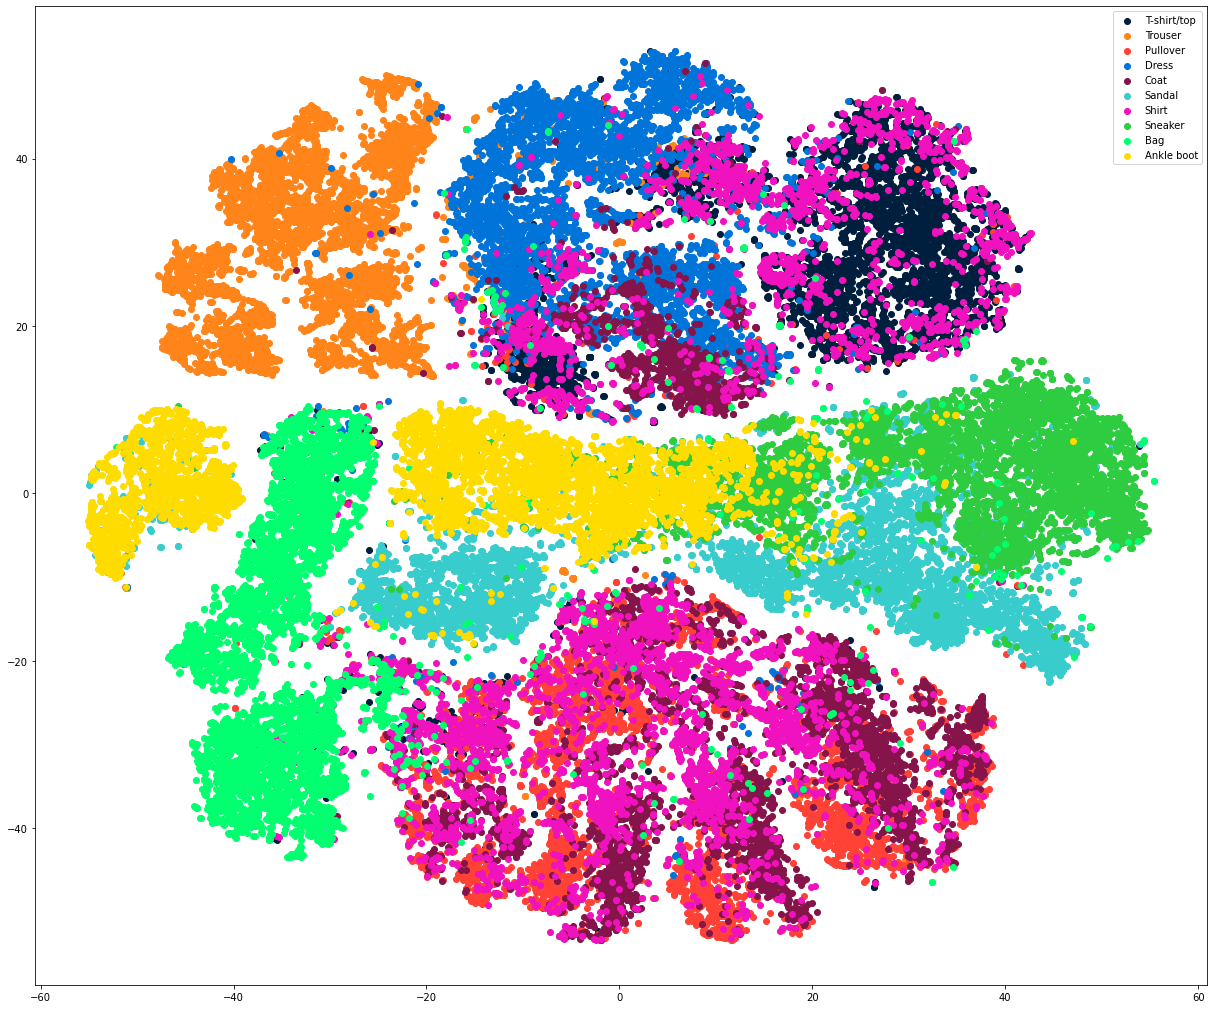

In [16]:
plot_tsne_embedding(X_train_tsne, y_train)

In [17]:
def plot_tsne_embedding_v2(X, X_origin, title=None, dims=[None, 28, 28]):
    dims[0] = X.shape[0]
    X_origin = X_origin.astype(float).reshape(dims)
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(
            X[i, 0],
            X[i, 1],
            str(y_train[i]),
            color=plt.cm.Set1(y_train.astype(int)[i] / 10.0),
            fontdict={"weight": "bold", "size": 9},
        )

    if hasattr(offsetbox, "AnnotationBbox"):
        shown_images = np.array([[1.0, 1.0]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 3e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(X_origin[i], cmap=plt.cm.gray_r), X[i]
            )
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

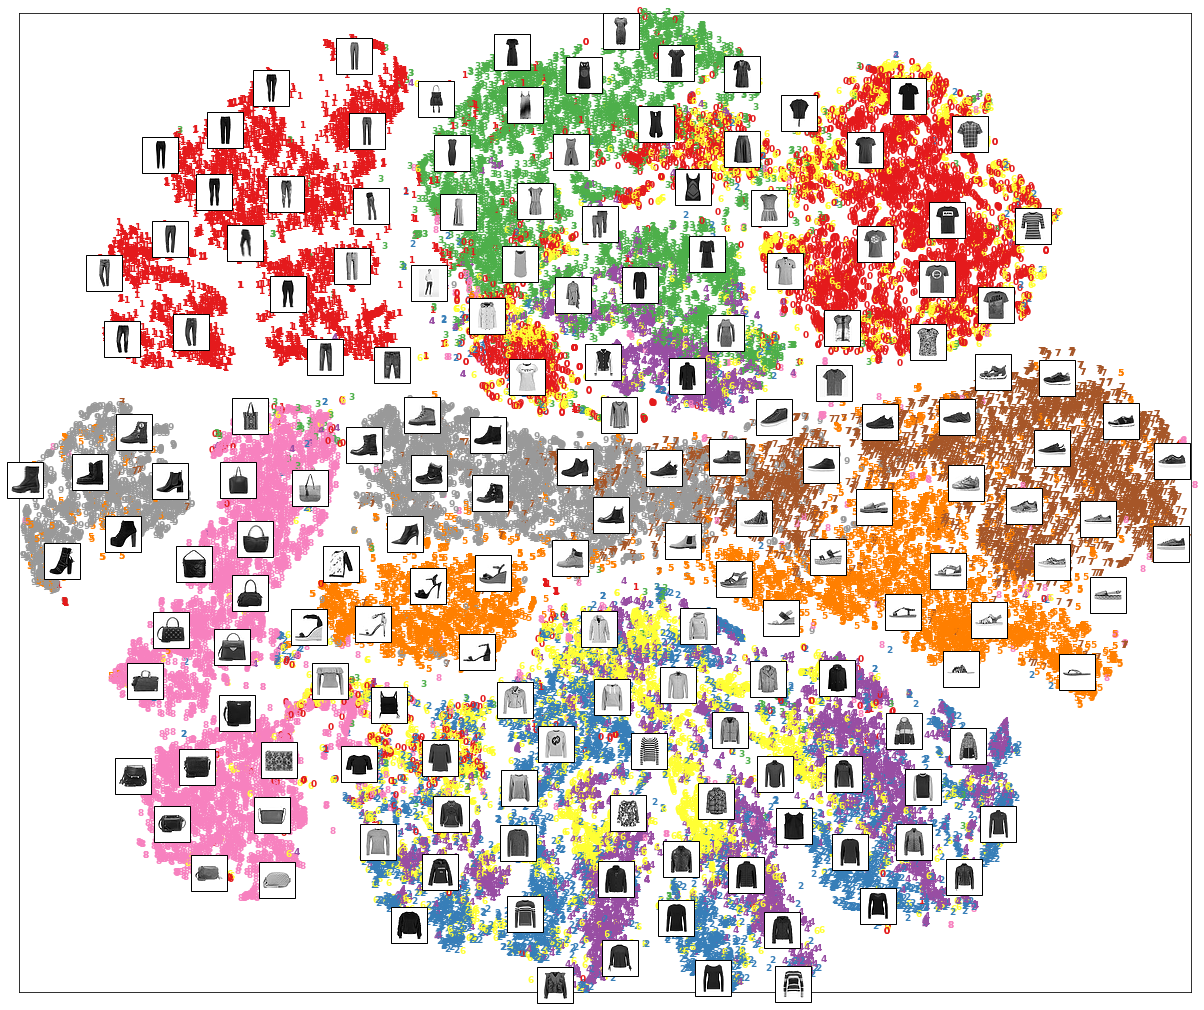

In [18]:
plot_tsne_embedding_v2(X_train_tsne, X_train)

### Hyperparameter Tuning

In [19]:
SEED = 123456

np.random.seed(SEED)
tf.random.set_seed(SEED)

In [20]:
def clean_up(model_):
    tf.keras.backend.clear_session()
    del model_
    gc.collect()

In [21]:
def mlp_model_builder(hp):
    """Creates a HyperModel instance (or callable that takes hyperparameters and returns a Model instance)."""
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4, 4 * 1e-4])

    model = tf.keras.Sequential(
        [
            tf.keras.layers.Flatten(input_shape=(28, 28)),
            tf.keras.layers.Rescaling(scale=1.0 / 255),
            tf.keras.layers.Dense(
                units=hp.Int("1l_units", min_value=256, max_value=384, step=16),
                kernel_initializer="glorot_uniform",
                activation="relu",
            ),
            tf.keras.layers.Dropout(
                rate=hp.Float("dropout", min_value=0.0, max_value=0.6, step=0.1)
            ),
            tf.keras.layers.Dense(
                units=hp.Int("2l_units", min_value=256, max_value=384, step=16),
                kernel_initializer="glorot_uniform",
                activation="relu",
            ),
            tf.keras.layers.Dense(
                units=10,
                kernel_initializer="glorot_uniform",
            ),
        ]
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )

    return model

In [26]:
# Li, Lisha, and Kevin Jamieson.
# "Hyperband: A Novel Bandit-Based Approach to Hyperparameter Optimization."
# Journal of Machine Learning Research 18 (2018): 1-52.
# https://jmlr.org/papers/v18/16-558.html
tuner = kt.Hyperband(
    mlp_model_builder,
    objective="val_accuracy",
    max_epochs=50,  # the maximum number of epochs to train one model
    seed=SEED,
    directory="hparam-tuning",
    project_name="mlp",
)

In [27]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

In [28]:
tuner.search(
    train_images, train_labels, epochs=50, validation_split=0.2, callbacks=[stop_early]
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(
    f"""
The hyperparameter search is complete. \n

Results
=======
|
---- optimal number of units in the first densely-connected layer  : {best_hps.get('1l_units')}
|
---- optimal number of units in the second densely-connected layer : {best_hps.get('2l_units')}
|
---- optimal dropout rate                                          : {best_hps.get('dropout')}
|
---- optimal learning rate for the optimizer                       : {best_hps.get('learning_rate')}
"""
)

Trial 90 Complete [00h 03m 33s]
val_accuracy: 0.8972499966621399

Best val_accuracy So Far: 0.9016666412353516
Total elapsed time: 01h 37m 46s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. 


Results
|
---- optimal number of units in the first densely-connected layer  : 304
|
---- optimal number of units in the second densely-connected layer : 256
|
---- optimal dropout rate                                          : 0.30000000000000004
|
---- optimal learning rate for the optimizer                       : 0.0004



#### Model Selection

In [29]:
model = tuner.get_best_models(num_models=1)[0]

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 rescaling (Rescaling)       (None, 784)               0         
                                                                 
 dense (Dense)               (None, 304)               238640    
                                                                 
 dropout (Dropout)           (None, 304)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               78080     
                                                                 
 dense_2 (Dense)             (None, 10)                2570      
                                                                 
Total params: 319,290
Trainable params: 319,290
Non-trai

In [30]:
clean_up(model)

In [31]:
# build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_images, train_labels, epochs=50, validation_split=0.2)

# keep best epoch
val_acc_per_epoch = history.history["val_accuracy"]
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print("Best epoch: %d" % (best_epoch,))

Epoch 1/50
1500/1500 [==============================] - 13s 8ms/step - loss: 0.5535 - accuracy: 0.8050 - val_loss: 0.4468 - val_accuracy: 0.8365
Epoch 2/50
1500/1500 [==============================] - 12s 8ms/step - loss: 0.4064 - accuracy: 0.8522 - val_loss: 0.3875 - val_accuracy: 0.8572
Epoch 3/50
1500/1500 [==============================] - 13s 9ms/step - loss: 0.3680 - accuracy: 0.8660 - val_loss: 0.3649 - val_accuracy: 0.8723
Epoch 4/50
1500/1500 [==============================] - 14s 9ms/step - loss: 0.3461 - accuracy: 0.8720 - val_loss: 0.3422 - val_accuracy: 0.8763
Epoch 5/50
1500/1500 [==============================] - 11s 7ms/step - loss: 0.3292 - accuracy: 0.8794 - val_loss: 0.3266 - val_accuracy: 0.8813
Epoch 6/50
1500/1500 [==============================] - 13s 9ms/step - loss: 0.3187 - accuracy: 0.8815 - val_loss: 0.3191 - val_accuracy: 0.8863
Epoch 7/50
1500/1500 [==============================] - 13s 9ms/step - loss: 0.3040 - accuracy: 0.8866 - val_loss: 0.3245 - val_ac

Best epoch: 49


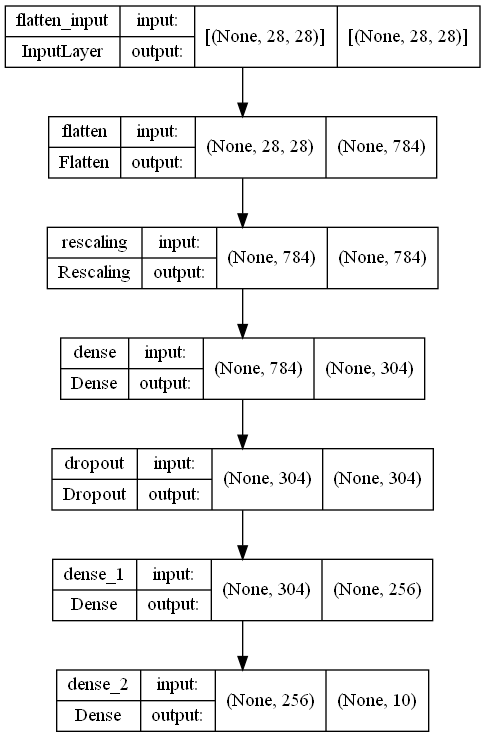

In [32]:
tf.keras.utils.plot_model(
    model, to_file="static/mlp_model.png", show_shapes=True, show_layer_names=True
)

In [33]:
clean_up(model)

In [34]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
history = hypermodel.fit(
    train_images, train_labels, epochs=best_epoch, validation_split=0.2
)

Epoch 1/49
1500/1500 [==============================] - 13s 8ms/step - loss: 0.5556 - accuracy: 0.8031 - val_loss: 0.4366 - val_accuracy: 0.8438
Epoch 2/49
1500/1500 [==============================] - 11s 8ms/step - loss: 0.4063 - accuracy: 0.8523 - val_loss: 0.3652 - val_accuracy: 0.8685
Epoch 3/49
1500/1500 [==============================] - 10s 7ms/step - loss: 0.3677 - accuracy: 0.8654 - val_loss: 0.3764 - val_accuracy: 0.8677
Epoch 4/49
1500/1500 [==============================] - 12s 8ms/step - loss: 0.3478 - accuracy: 0.8724 - val_loss: 0.3469 - val_accuracy: 0.8732
Epoch 5/49
1500/1500 [==============================] - 12s 8ms/step - loss: 0.3277 - accuracy: 0.8788 - val_loss: 0.3316 - val_accuracy: 0.8788
Epoch 6/49
1500/1500 [==============================] - 13s 8ms/step - loss: 0.3167 - accuracy: 0.8823 - val_loss: 0.3212 - val_accuracy: 0.8833
Epoch 7/49
1500/1500 [==============================] - 10s 6ms/step - loss: 0.3047 - accuracy: 0.8860 - val_loss: 0.3132 - val_ac

### Evaluation

In [35]:
eval_result = hypermodel.evaluate(test_images, test_labels, verbose=3)
print("[test loss, test accuracy]:", eval_result)

[test loss, test accuracy]: [0.3618339002132416, 0.896399974822998]


In [36]:
def plot_history(hs, epochs, metric):
    print()
    plt.style.use("dark_background")
    plt.rcParams["figure.figsize"] = [15, 8]
    plt.rcParams["font.size"] = 16
    plt.clf()
    for label in hs:
        plt.plot(
            hs[label].history[metric],
            label="{0:s} train {1:s}".format(label, metric),
            linewidth=2,
        )
        plt.plot(
            hs[label].history["val_{0:s}".format(metric)],
            label="{0:s} validation {1:s}".format(label, metric),
            linewidth=2,
        )
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks[0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel("Epochs")
    plt.ylabel("Loss" if metric == "loss" else "Accuracy")
    plt.legend()
    plt.show()

Train Loss         : 0.14191
Validation Loss    : 0.31933
Test Loss          : 0.36183
----------------------------
Train Accuracy     : 0.94590
Validation Accuracy: 0.90358
Test Accuracy      : 0.89640



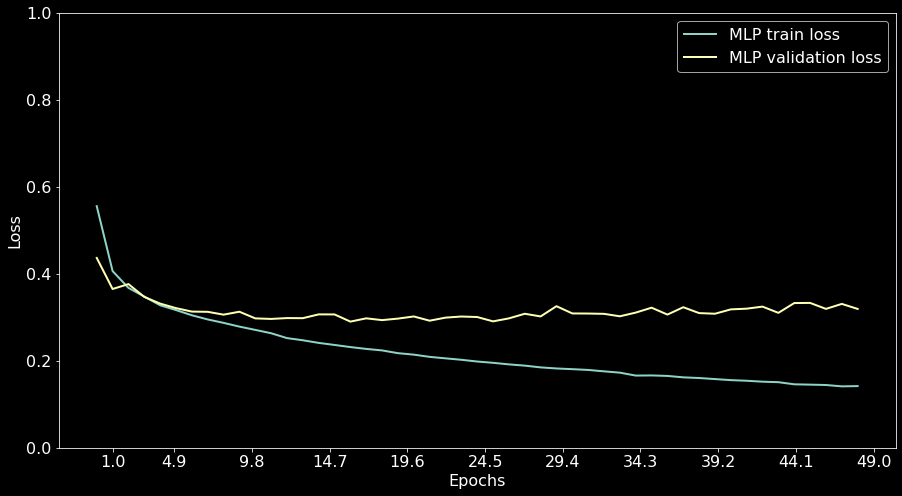

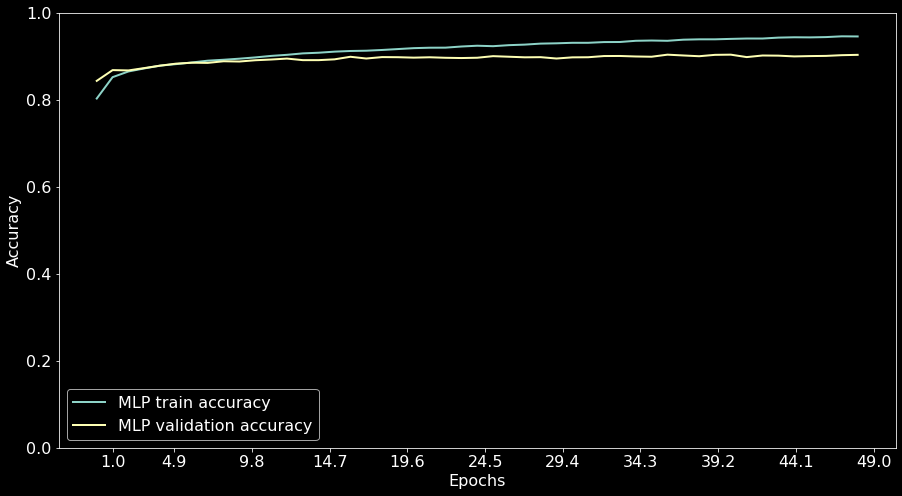

In [40]:
print("Train Loss         : {0:.5f}".format(history.history["loss"][-1]))
print("Validation Loss    : {0:.5f}".format(history.history["val_loss"][-1]))
print("Test Loss          : {0:.5f}".format(eval_result[0]))
print("----------------------------")
print("Train Accuracy     : {0:.5f}".format(history.history["accuracy"][-1]))
print("Validation Accuracy: {0:.5f}".format(history.history["val_accuracy"][-1]))
print("Test Accuracy      : {0:.5f}".format(eval_result[1]))

# Plot train and validation error per epoch.
plot_history(hs={"MLP": history}, epochs=best_epoch, metric="loss")
plot_history(hs={"MLP": history}, epochs=best_epoch, metric="accuracy")

In [41]:
def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.PuBuGn
):

    plt.style.use("default")
    plt.rcParams["figure.figsize"] = [11, 9]
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

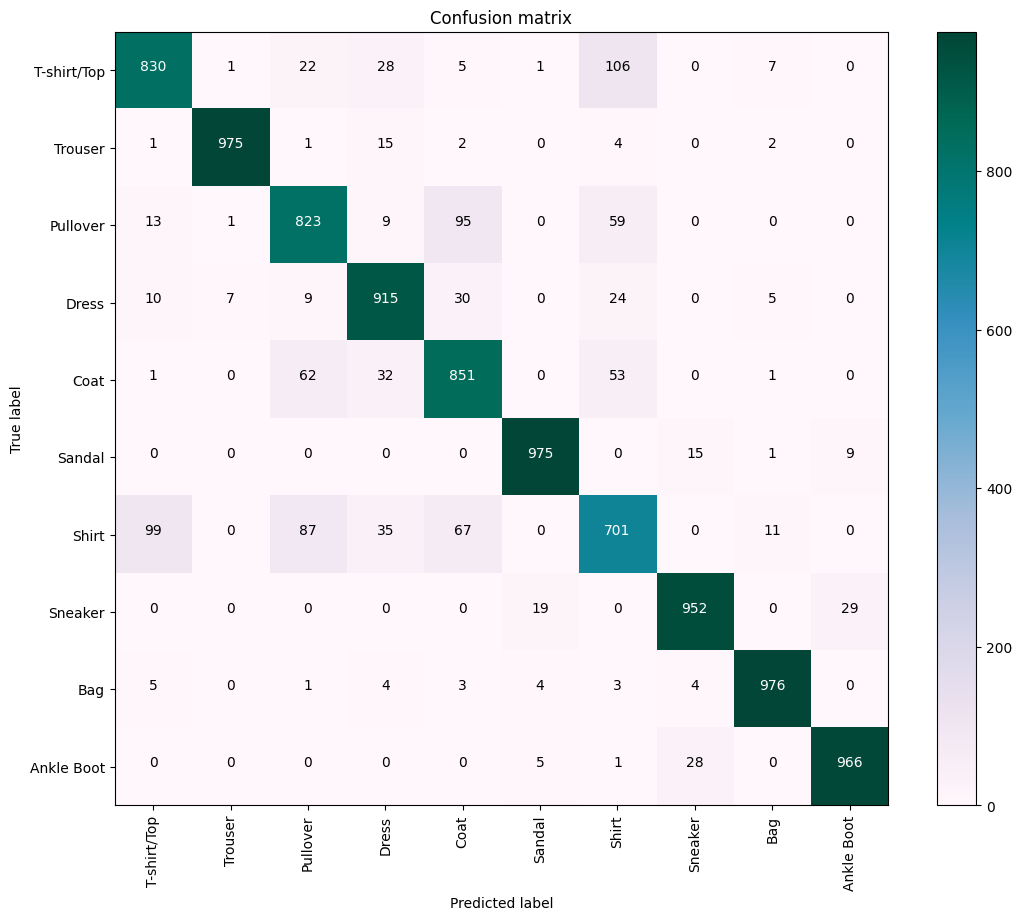

In [42]:
# Predict the values from the validation dataset
Y_pred = hypermodel.predict(test_images)

# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)

# compute the confusion matrix
confusion_mtx = confusion_matrix(test_labels, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(
    confusion_mtx,
    classes=class_names,
)

In [43]:
incorrect = []
for i in range(len(test_labels)):
    if not Y_pred_classes[i] == test_labels[i]:
        incorrect.append(i)
    if len(incorrect) == 4:
        break

Text(0.5, 1.0, 'Predicted Label : T-shirt/top\nActual Label : Shirt')

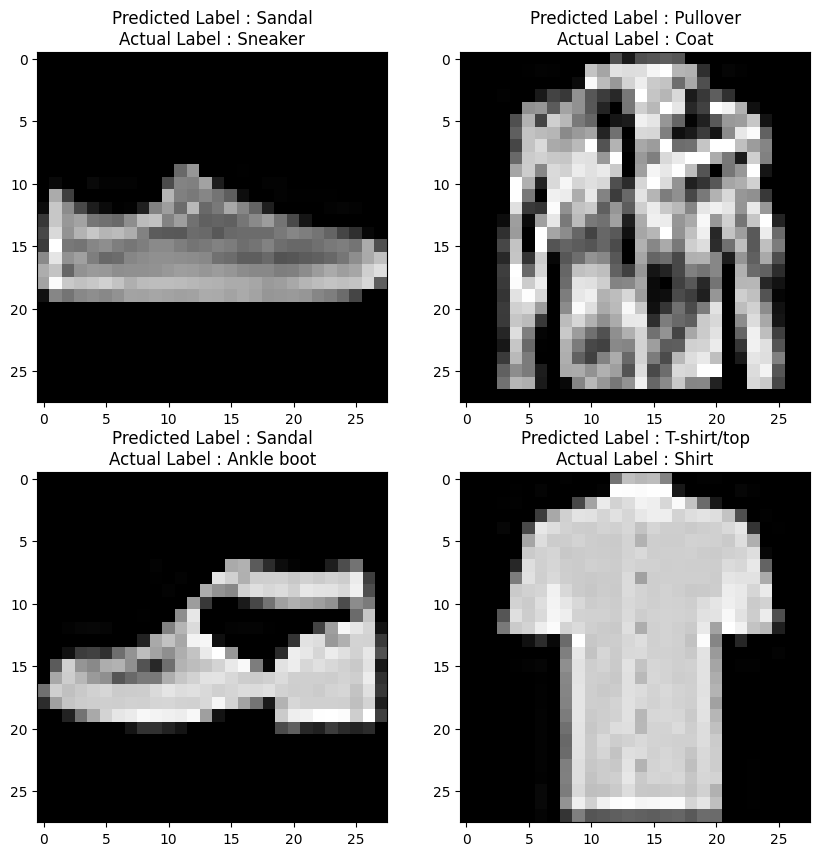

In [44]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
fig.set_size_inches(10, 10)
ax[0, 0].imshow(test_images[incorrect[0]].reshape(28, 28), cmap="gray")

ax[0, 0].set_title(
    "Predicted Label : "
    + class_names[Y_pred_classes[incorrect[0]]]
    + "\n"
    + "Actual Label : "
    + class_names[test_labels[incorrect[0]]]
)
ax[0, 1].imshow(test_images[incorrect[1]].reshape(28, 28), cmap="gray")
ax[0, 1].set_title(
    "Predicted Label : "
    + class_names[Y_pred_classes[incorrect[1]]]
    + "\n"
    + "Actual Label : "
    + class_names[test_labels[incorrect[1]]]
)
ax[1, 0].imshow(test_images[incorrect[2]].reshape(28, 28), cmap="gray")
ax[1, 0].set_title(
    "Predicted Label : "
    + class_names[Y_pred_classes[incorrect[2]]]
    + "\n"
    + "Actual Label : "
    + class_names[test_labels[incorrect[2]]]
)
ax[1, 1].imshow(test_images[incorrect[3]].reshape(28, 28), cmap="gray")
ax[1, 1].set_title(
    "Predicted Label : "
    + class_names[Y_pred_classes[incorrect[3]]]
    + "\n"
    + "Actual Label : "
    + class_names[test_labels[incorrect[3]]]
)